### Data sampling with a sliding window

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import re
import tiktoken

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt) #A
        for i in range(0, len(token_ids) - max_length, stride): #B
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self): #C
        return len(self.input_ids)
    def __getitem__(self, idx): #D
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2") #A
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) #B
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last, #C
        num_workers=0 #D
    )
    return dataloader

In [4]:
with open("../data/raw/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader) #A
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [5]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [2]:
import torch

## Token Embeddings
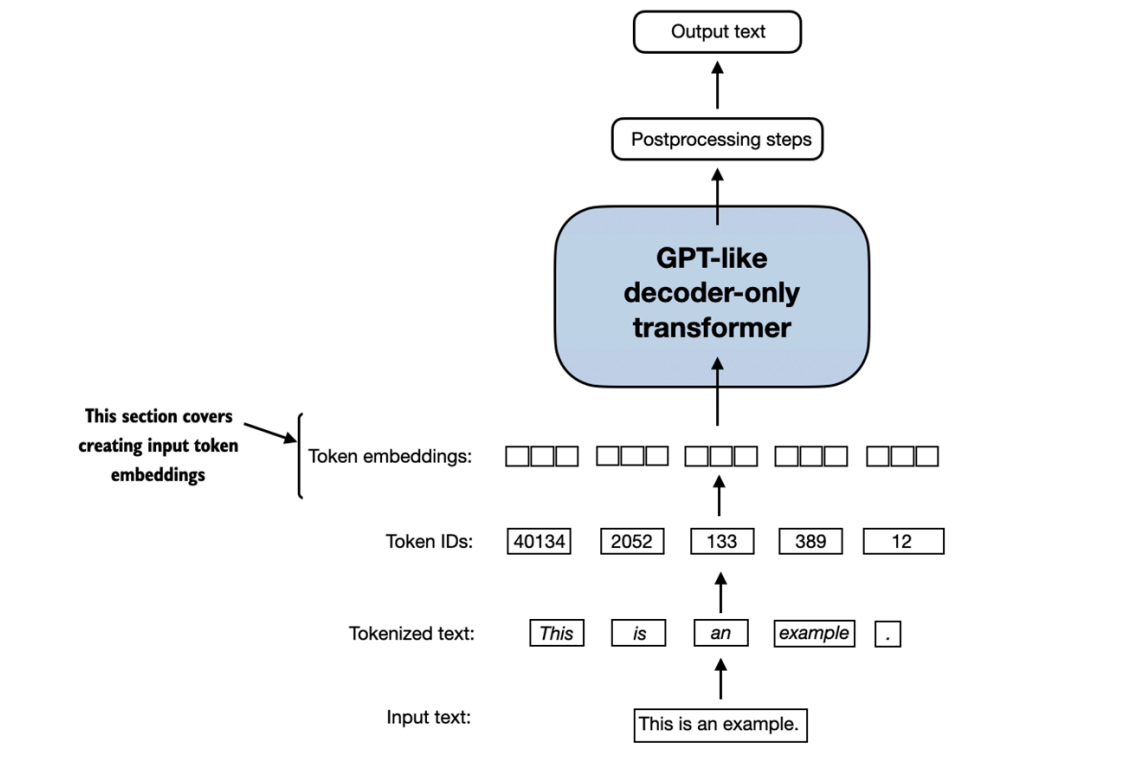

In [4]:
# tokens with IDs
input_ids = torch.tensor([2, 3, 5, 1])
input_ids

tensor([2, 3, 5, 1])

it is important to note that we initialize
these embedding weights with random values as a preliminary step. This initialization
serves as the starting point for the LLM's learning process.

In [5]:
vocab_size = 6 #only 6 words in our vocab
output_dim = 3

In [6]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight) # we can see that the weight matrix has six rows and three columns. There is one row for each of the six possible tokens in the vocabulary.

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


We can see that the weight matrix of the embedding layer contains small, random values.
These values are optimized during LLM training as part of the LLM optimization itself, as we
will see in upcoming sessions.

Let's now apply that to all four input IDs into a three-dimensional
embedding vector.
(torch.tensor([2, 3, 5, 1])):
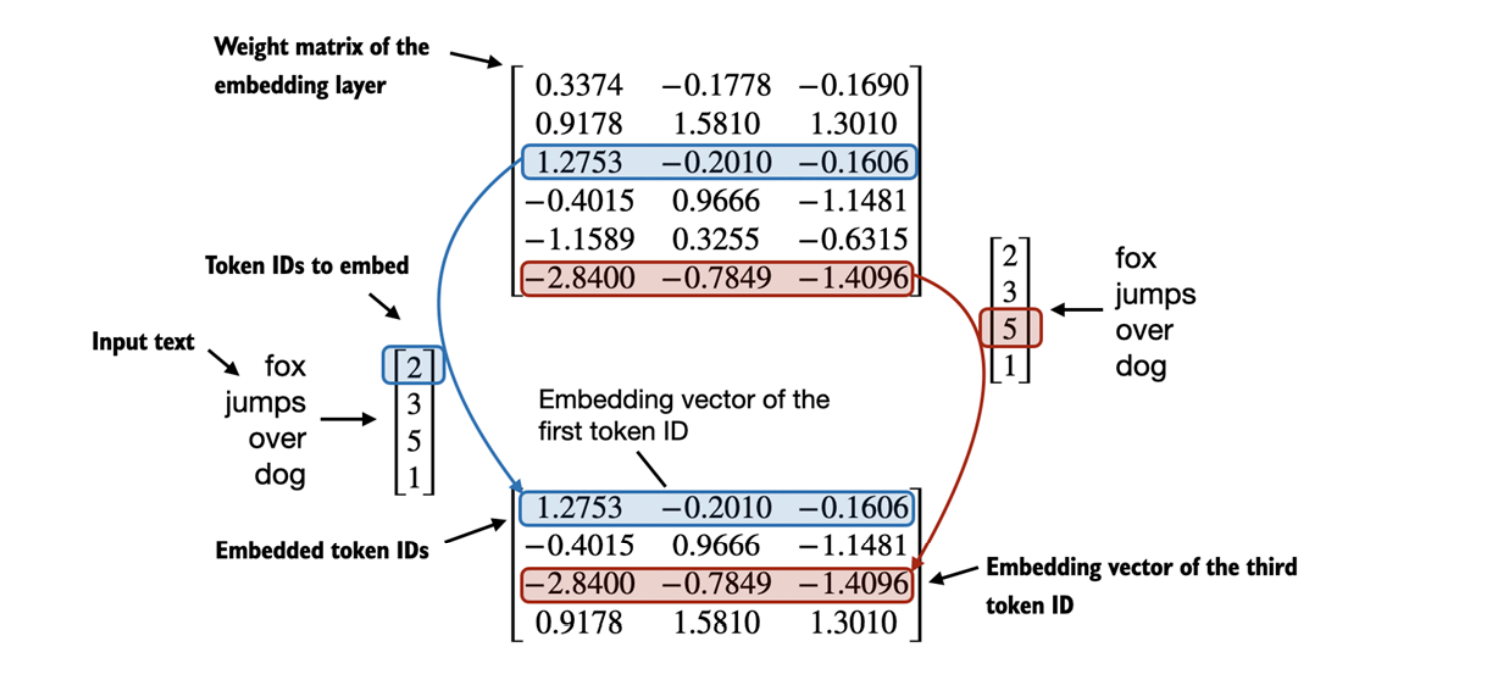

In [9]:
print(embedding_layer(input_ids)) # The print output reveals that this results in a 4x3 matrix

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


## Encoding word positions
doesn't have a notion of position or order for the
tokens within a sequence.
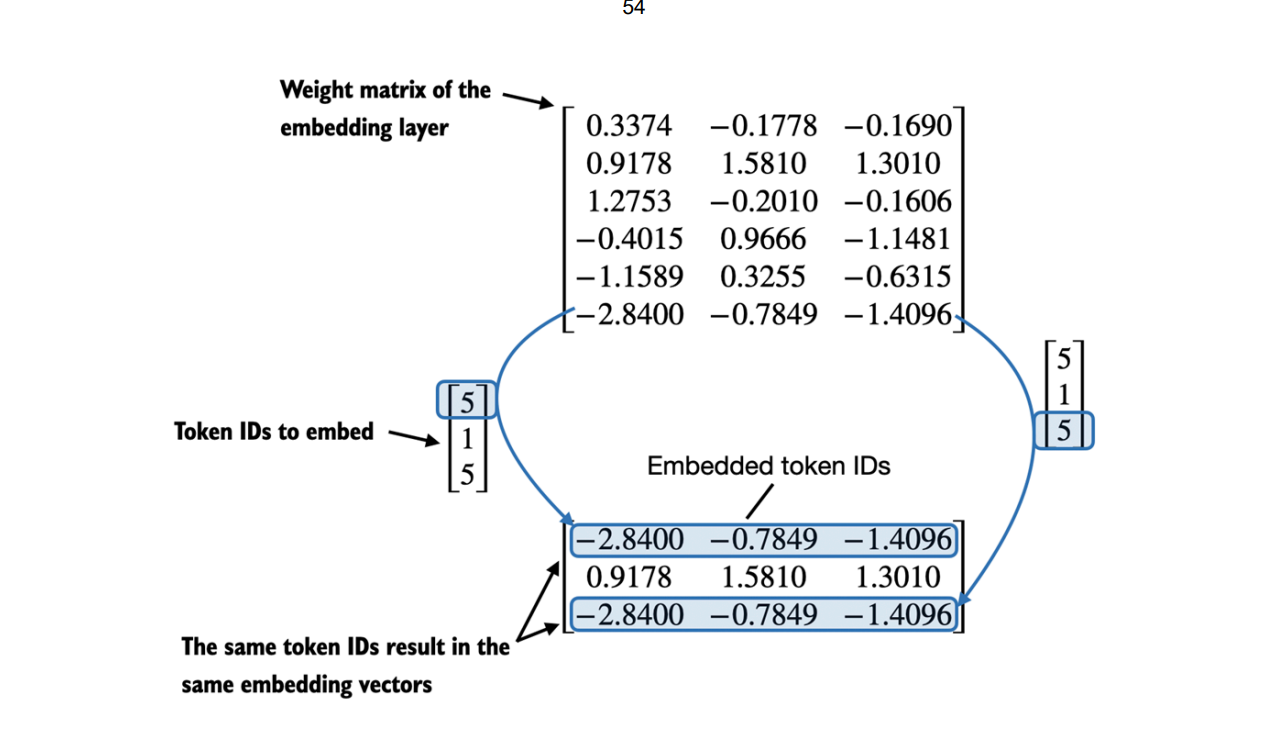
The embedding layer converts a token ID into the same vector representation regardless of where
it is located in the input sequence. For example, the token ID 5, whether it's in the first or third position in the
token ID input vector, will result in the same embedding vector.


**Positional embeddings** are added to the token embedding vector to create the input embeddings
for an LLM. The positional vectors have the same dimension as the original token embeddings. The token
embeddings are shown with value 1 for simplicity.
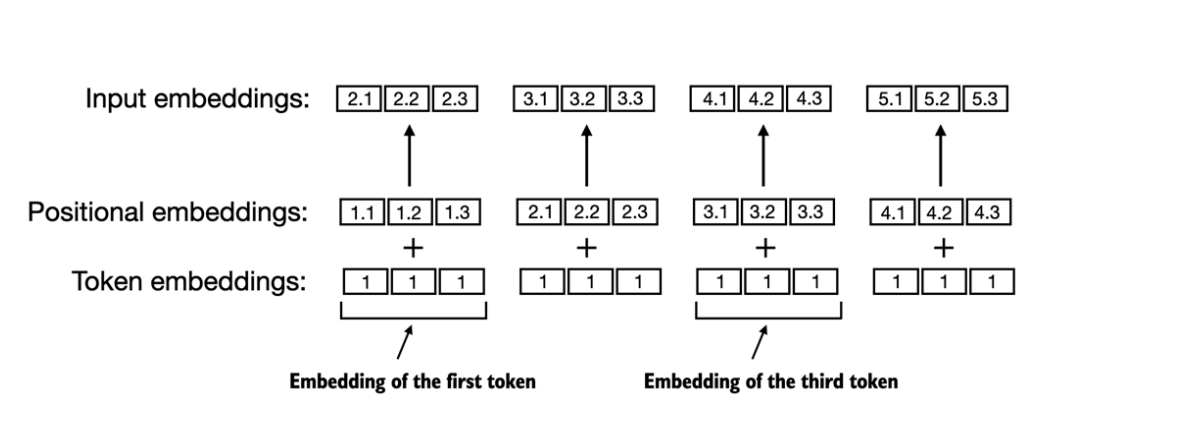

In [6]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

Using the token_embedding_layer above, if we sample data from the data loader, we
embed each token in each batch into a 256-dimensional vector. If we have a batch size of 8
with four tokens each, the result will be an 8 x 4 x 256 tensor.


In [7]:
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


now use the embedding layer to embed these token IDs into 256-dimensional
vectors:

In [8]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


 - 8 documents
 - each with 4 words
 - each word represented by 256 numbers

In [10]:
token_embeddings[0].shape

torch.Size([4, 256])

For a **GPT model's** absolute embedding approach, we just need to create another
embedding layer that has the same dimension as the token_embedding_layer:

In [11]:
output_dim

256

In [13]:
max_length

4

In [12]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [14]:
pos_embeddings

tensor([[-0.4221,  0.6934, -0.4320,  ..., -0.8176,  1.2768, -1.3253],
        [ 0.4048,  0.5792, -0.7045,  ...,  0.6513, -0.3497, -1.0674],
        [ 0.3106, -0.9765, -1.2809,  ..., -1.4028,  0.1872, -0.5296],
        [-0.2554, -1.1724,  0.4735,  ...,  0.5922,  1.1220,  0.8318]],
       grad_fn=<EmbeddingBackward0>)

In [15]:
pos_embedding_layer

Embedding(4, 256)

In [16]:
token_embeddings

tensor([[[-4.6671e-01,  1.1198e-01,  2.8295e-01,  ...,  2.7791e-01,
           6.5231e-02, -2.9103e-02],
         [ 4.4060e-01,  1.8506e-01, -1.1221e+00,  ..., -3.4264e-01,
          -1.4859e+00, -3.7077e-01],
         [-1.5338e+00,  1.2963e+00, -1.7770e+00,  ...,  3.1559e-01,
           2.7039e-01, -1.6473e+00],
         [-1.3729e-01,  1.1145e+00, -1.1297e+00,  ...,  3.2110e-01,
           1.8728e+00,  7.8641e-01]],

        [[ 8.7232e-01, -5.5990e-01, -8.8753e-01,  ..., -5.6077e-01,
           2.3258e+00,  8.1075e-01],
         [-1.6807e+00,  2.3107e+00,  7.2030e-01,  ..., -9.3655e-01,
          -1.2415e+00,  3.1573e-01],
         [ 8.4621e-01,  1.8435e+00, -4.9106e-01,  ...,  5.5967e-01,
          -3.7131e-01, -8.9261e-01],
         [ 6.4017e-01,  7.0714e-01, -7.5059e-01,  ...,  1.3201e+00,
          -9.0263e-02,  1.2200e+00]],

        [[-1.6619e+00, -4.1898e-01,  3.2335e-01,  ...,  1.2291e+00,
          -6.8482e-01,  4.7829e-02],
         [ 1.7316e+00,  8.3991e-01, -1.3692e-01,  .